In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='bp_res1', ylabel='energy_diff'>

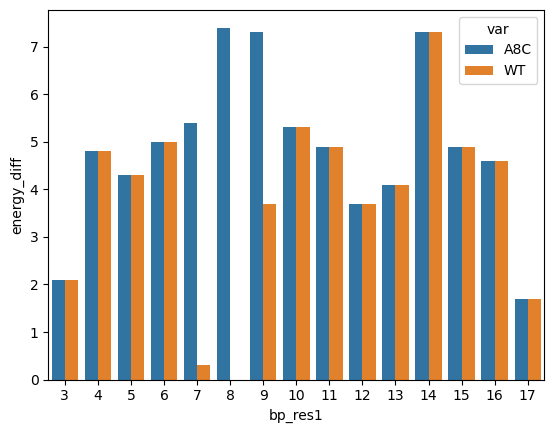

In [35]:
dG = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/dGcorrplot_new.csv', index_col=0)
# drop 'old' and 'oldnmr'
dG = dG.drop(columns=['old', 'oldnmr'])


nn_a8c = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/fourU_A8C_energy_calc.csv')
nn_wt = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/fourU_WT_energy_calc.csv')
nn_a8c['var'] = 'A8C'
nn_wt['var'] = 'WT'
nn = pd.concat([nn_a8c, nn_wt])

# drop 'energy' and 'err'
nn = nn.drop(columns=['energy', 'err'])
# filter res1 > -1
nn = nn[nn['bp_res1'] > -1]
nn.sort_values(by='bp_res1', inplace=True)

nn['bp_res1'] = nn['bp_res1'] - 18
nn['bp_res2'] = nn['bp_res2'] - 18
nn['res1_sitent'] = nn['bp_res1'].astype(str) + nn['bp_base1']
nn['res2_sitent'] = nn['bp_res2'].astype(str) + nn['bp_base2']

sns.barplot(x='bp_res1', y='energy_diff', hue='var', data=nn)

<Axes: xlabel='site', ylabel='new'>

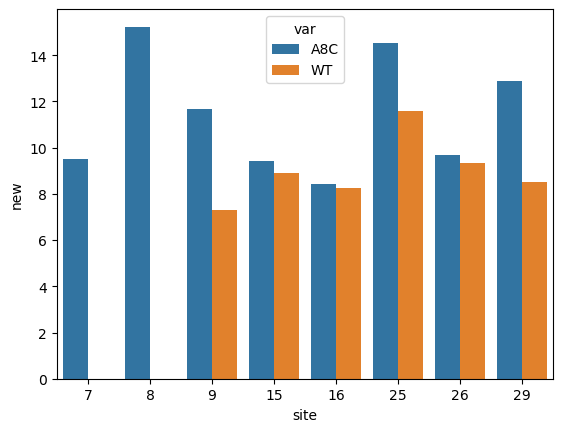

In [15]:
sns.barplot(x='site', y='new', hue='var', data=dG)

In [47]:
from lmfit.models import LinearModel

In [84]:
a8c_bp_prob = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.001.NN_penalty/fourU_thermometer/pfunc_calcs_20/fourU_A8C_pfunc_bp_prob.csv')
wt_bp_prob = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.001.NN_penalty/fourU_thermometer/pfunc_calcs_20/fourU_WT_pfunc_bp_prob.csv')

a8c_bp_prob['var'] = 'A8C'
wt_bp_prob['var'] = 'WT'

bp_prob = pd.concat([a8c_bp_prob, wt_bp_prob])
bp_prob['bp_res1'] = bp_prob['bp_res1'] - 18
bp_prob['bp_res2'] = bp_prob['bp_res2'] - 18

nn = nn.merge(bp_prob, on = ['bp_res1', 'bp_res2', 'var'])

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 1.45238060
    reduced chi-square = 0.12103172
    Akaike info crit   = -27.7219465
    Bayesian info crit = -26.4438319
    R-squared          = 0.66906112
[[Variables]]
    slope:      0.35828238 +/- 0.07274042 (20.30%) (init = 1)
    intercept:  0.52945571 +/- 0.40668709 (76.81%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9735


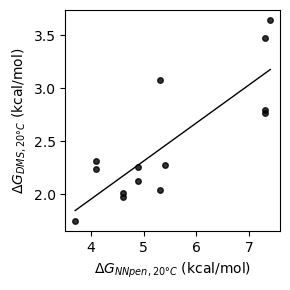

In [115]:
nn

pt1 = dG.merge(nn, left_on=['site', 'var'], right_on=['bp_res1', 'var'])
pt2 = dG.merge(nn, left_on=['site', 'var'], right_on=['bp_res2', 'var'])

merged = pd.concat([pt1, pt2])
merged = merged[['site', 'var', 'new', 'energy_diff', 'prob']]
merged['loglog_prob'] = -np.log(-np.log(merged['prob']))


# use LinearModel
model = LinearModel()
result = model.fit(x = merged['energy_diff'], data = merged['new'] / 4.184)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.regplot(x = merged['energy_diff'], y = merged['new'] / 4.184, robust = True, ci = None, 
            ax = ax, color = 'black', line_kws = {'linewidth': '1'}, scatter_kws={'s': 16})
ax.set_xlabel(r'$\Delta G_{NNpen, 20°C}$ (kcal/mol)')
ax.set_ylabel(r'$\Delta G_{DMS, 20°C}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/dGcorrplot_NN.pdf')


In [99]:
### getting imino NMR stuff

temp = 20
nmr_imino_params = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.040.analysis_workflow2.0/workflow/data/nmr_imino/imino_ref_values.csv')
nmr_imino_params['dS'] /= 1000 # convert to kJ/mol
nmr_imino_params['dG_nmr'] = nmr_imino_params['dH'] - (temp + 273.15) * nmr_imino_params['dS']
nmr_imino_params.sort_values(['var', 'site_comp'], ascending = [False, True], inplace = True)
nmr_imino_params = nmr_imino_params[nmr_imino_params['site_comp'] < 34]
nmr_imino_params

nmr_wt = nmr_imino_params[nmr_imino_params['var'] == 'WT'][['site_comp', 'dG_nmr']]
nmr_a8c = nmr_imino_params[nmr_imino_params['var'] == 'A8C'][['site_comp', 'dG_nmr']]

# merge nmr_wt, nmr_a8c to calculate ddG
nmr_wt.columns = ['site_comp', 'dG_nmr_wt']
nmr_a8c.columns = ['site_comp', 'dG_nmr_a8c']
nmr_ddG = nmr_wt.merge(nmr_a8c, on = 'site_comp', how = 'inner')
nmr_ddG['ddG'] = nmr_ddG['dG_nmr_a8c'] - nmr_ddG['dG_nmr_wt']

nmr_wt['var'] = 'WT'
nmr_wt['dG_nmr'] = nmr_wt['dG_nmr_wt']
nmr_a8c['var'] = 'A8C'
nmr_a8c['dG_nmr'] = nmr_a8c['dG_nmr_a8c']

nmr = pd.concat([nmr_wt, nmr_a8c])

merged_nmr = merged.merge(nmr, left_on = ['site', 'var'], right_on = ['site_comp', 'var'])
# drop site_comp, dG_nmr_wt, dG_nmr_a8c
merged_nmr = merged_nmr.drop(columns = ['site_comp', 'dG_nmr_wt', 'dG_nmr_a8c'])
merged_nmr

,site,var,new,energy_diff,prob,loglog_prob,dG_nmr
0,7,A8C,9.516889,5.4,0.999903,9.236965,14.90315
1,8,A8C,15.234389,7.4,0.999997,12.679664,39.56785
2,9,A8C,11.689616,7.3,0.999996,12.508317,28.40060
3,9,WT,7.304047,3.7,0.997888,6.159142,17.02680
4,15,A8C,9.427275,4.9,0.999720,8.181103,17.28810
5,15,WT,8.904474,4.9,0.999720,8.180585,16.64215
6,16,A8C,8.408594,4.6,0.991897,4.811474,10.45375
7,16,WT,8.246938,4.6,0.991897,4.811465,10.31145
8,25,A8C,14.524144,7.3,0.999996,12.343115,38.13875
9,25,WT,11.582086,7.3,0.999995,12.241099,28.43980


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.95319985
    reduced chi-square = 0.07943332
    Akaike info crit   = -33.6178323
    Bayesian info crit = -32.3397176
    R-squared          = 0.78280425
[[Variables]]
    slope:      0.22305585 +/- 0.03391736 (15.21%) (init = 1)
    intercept:  1.39592240 +/- 0.18117266 (12.98%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9095


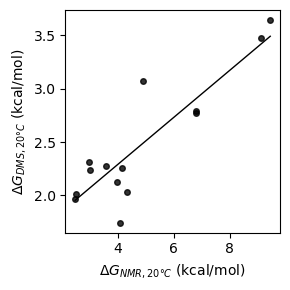

In [116]:
# use LinearModel
model = LinearModel()
result = model.fit(x = merged_nmr['dG_nmr'] / 4.184, data=merged_nmr['new'] / 4.184)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.regplot(x = merged_nmr['dG_nmr'] / 4.184, y = merged_nmr['new'] / 4.184, robust = True, ci = None, 
            ax = ax, color = 'black', line_kws = {'linewidth': '1'}, scatter_kws={'s': 16})
ax.set_xlabel(r'$\Delta G_{NMR, 20°C}$ (kcal/mol)')
ax.set_ylabel(r'$\Delta G_{DMS, 20°C}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/dGcorrplot_nmr.pdf')


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 4.58696332
    reduced chi-square = 0.38224694
    Akaike info crit   = -11.6217475
    Bayesian info crit = -10.3436329
    R-squared          = 0.79947075
[[Variables]]
    slope:      0.51463080 +/- 0.07440339 (14.46%) (init = 1)
    intercept:  2.94276277 +/- 0.39743243 (13.51%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9095


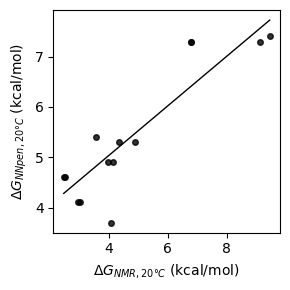

In [117]:
# use LinearModel
model = LinearModel()
result = model.fit(x = merged_nmr['dG_nmr'] / 4.184, data = merged_nmr['energy_diff'])
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.regplot(x = merged_nmr['dG_nmr'] / 4.184, y = merged_nmr['energy_diff'], robust = True, ci = None, 
            ax = ax, color = 'black', line_kws = {'linewidth': '1'}, scatter_kws={'s': 16})
ax.set_xlabel(r'$\Delta G_{NMR, 20°C}$ (kcal/mol)')
ax.set_ylabel(r'$\Delta G_{NNpen, 20°C}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/dGcorrplot_nmr_v_nn.pdf')


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 1.25189060
    reduced chi-square = 0.10432422
    Akaike info crit   = -29.8016342
    Bayesian info crit = -28.5235196
    R-squared          = 0.71474469
[[Variables]]
    slope:      0.17553198 +/- 0.03201157 (18.24%) (init = 1)
    intercept:  0.95751230 +/- 0.29068310 (30.36%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9549


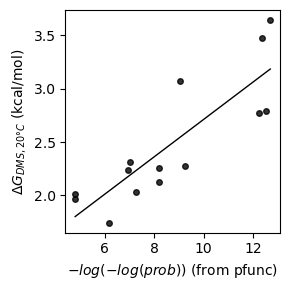

In [118]:
# use LinearModel
model = LinearModel()
result = model.fit(x = merged_nmr['loglog_prob'], data = merged_nmr['new'] / 4.184)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.regplot(x = merged_nmr['loglog_prob'], y = merged_nmr['new'] / 4.184, robust = True, ci = None, 
            ax = ax, color = 'black', line_kws = {'linewidth': '1'}, scatter_kws={'s': 16})
ax.set_xlabel(r'$-log(-log(prob))$ (from pfunc)')
ax.set_ylabel(r'$\Delta G_{DMS, 20°C}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/dGcorrplot_loglogprob.pdf')


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 3.41639346
    reduced chi-square = 0.28469946
    Akaike info crit   = -15.7466063
    Bayesian info crit = -14.4684916
    R-squared          = 0.85064480
[[Variables]]
    slope:      0.43718209 +/- 0.05288199 (12.10%) (init = 1)
    intercept:  1.65208761 +/- 0.48019821 (29.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9549


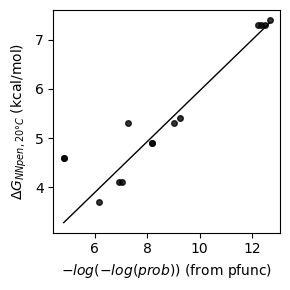

In [119]:
# use LinearModel
model = LinearModel()
result = model.fit(x = merged_nmr['loglog_prob'], data = merged_nmr['energy_diff'])
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.regplot(x = merged_nmr['loglog_prob'], y = merged_nmr['energy_diff'], robust = True, ci = None, 
            ax = ax, color = 'black', line_kws = {'linewidth': '1'}, scatter_kws={'s': 16})
ax.set_xlabel(r'$-log(-log(prob))$ (from pfunc)')
ax.set_ylabel(r'$\Delta G_{NNpen, 20°C}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('/Users/edricchoi/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.01_SHAPE_Standardization/Experiments/01.061.calculate_energy_correlations/01.061.002.correlation_dms_dG/dGcorrplot_loglogprob_NN.pdf')
